In [51]:
!pip install --upgrade pip
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install sklearn
!pip install kubernetes==26.1.0
!pip install prometheus-client

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
import numpy as np
from scipy.stats import norm



In [2]:
namespace = "social-application"

In [71]:
from kubernetes import client, config
import urllib3
urllib3.disable_warnings()
#connect to the cluster

aToken = ""
aConfiguration = client.Configuration()
aConfiguration.host = "https://api.cluster-lwrgl.lwrgl.sandbox2523.opentlc.com:6443"
aConfiguration.verify_ssl = False
aConfiguration.api_key = {"authorization": "Bearer " + aToken}

apiInstance = client.ApiClient(aConfiguration)

v1 = client.CoreV1Api(apiInstance)
print("Getting all pods")
ret = v1.list_pod_for_all_namespaces(watch=False)


# Do calls
# v1 = client.CustomObjectsApi(apiInstance)

# # get the info from the deployments
# print("Listing deployments")
# ret = v1.get_api_resources(group="apps.openshift.io", version="v1")
# print(ret)

# obj = v1.get_cluster_custom_object(group="apps.openshift.io", version="v1", plural="DeploymentConfig", name="deploymentconfigs")
# print(obj)



Listing pods with their IPs:


In [49]:
applications = {}
for i in ret.items:
    if(i.metadata.namespace == namespace):
        # print("%s\t%s\t%s" % (i.status.pod_ip, i.metadata.namespace, i.metadata.name))
        if("deploy" in i.metadata.name):
            continue
        if('openshift.io/deployment-config.name' in i.metadata.annotations.keys()):
            if(i.metadata.annotations['openshift.io/deployment-config.name'] in applications.keys()):
                applications[i.metadata.annotations['openshift.io/deployment-config.name']].append(i.metadata.name)
            else:
                applications[i.metadata.annotations['openshift.io/deployment-config.name']] = [i.metadata.name]
print(applications)

{'feed-service': ['feed-service-1-6zz26'], 'post-service': ['post-service-1-6dxwj', 'post-service-1-hh9cq', 'post-service-1-lxtpz'], 'user-service': ['user-service-1-nmflq']}


In [74]:
#connect to the phomethues and download the metrics
import requests

def getCpuUsage(namespace, podName, startDate, endDate):
    prometheus_url = "https://prometheus-k8s-openshift-monitoring.apps.cluster-lwrgl.lwrgl.sandbox2523.opentlc.com"
    prometheus_token = ""
    
    query = "/api/v1/query_range?query=pod%3Acontainer_cpu_usage%3Asum%7Bnamespace%3D%22"+ namespace + "%22%2C+pod%3D%22"+podName+"%22%7D&start="+ startDate + "&end="+endDate+"&step=2s"
    headers = {"authorization": "Bearer " + prometheus_token, 'Accept': 'application/json'}

    r = requests.get(prometheus_url+query, headers=headers)
    return r.json()

def getMemoryUsage(namespace, podName, startDate, endDate):
    prometheus_url = "https://prometheus-k8s-openshift-monitoring.apps.cluster-lwrgl.lwrgl.sandbox2523.opentlc.com"
    prometheus_token = "eyJhbGciOiJSUzI1NiIsImtpZCI6IjNYNXROakNZRFJEVWl2UlhHbVVLclNGeWk4ZC1LMDMtNlMzSzRjczJQRncifQ.eyJpc3MiOiJrdWJlcm5ldGVzL3NlcnZpY2VhY2NvdW50Iiwia3ViZXJuZXRlcy5pby9zZXJ2aWNlYWNjb3VudC9uYW1lc3BhY2UiOiJvcGVuc2hpZnQtbW9uaXRvcmluZyIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VjcmV0Lm5hbWUiOiJjbHVzdGVyLW1vbml0b3Jpbmctb3BlcmF0b3ItdG9rZW4tam5qOHciLCJrdWJlcm5ldGVzLmlvL3NlcnZpY2VhY2NvdW50L3NlcnZpY2UtYWNjb3VudC5uYW1lIjoiY2x1c3Rlci1tb25pdG9yaW5nLW9wZXJhdG9yIiwia3ViZXJuZXRlcy5pby9zZXJ2aWNlYWNjb3VudC9zZXJ2aWNlLWFjY291bnQudWlkIjoiOWIwMWNjNmYtMDJmMC00YTk4LWJjNGEtN2Q1N2RkYzE5ZjhkIiwic3ViIjoic3lzdGVtOnNlcnZpY2VhY2NvdW50Om9wZW5zaGlmdC1tb25pdG9yaW5nOmNsdXN0ZXItbW9uaXRvcmluZy1vcGVyYXRvciJ9.Qlhq_hyhQFZDxikCrue8hRtFfZudYdkZ9SBzOewIb95iqZnlVbxNJgZTHUL3emmkidQsNEH1FXwN1nu1Snl0EZglvfmfOOGdQidSlofiWec5JBNM2U6Y9dMVUL1F3d1rEl_57VuacDZ00jPCTJhyd2_PXcP7bgX6M7aK6eVwS-RYg7TUb4w2ApIWGSDd36WZrAHwaXE67xBTh9kOdlQlV_zuXzaJ3NOUu84oy968FhgKE5x6OA0OC5DTRJpLi0qnRVs1xsu2e2TMX5Lu2dZohYQ69Uv1CXfZMdM07p2V-7BaEcaN35PwGfEJSOPFx1Ea5xDuoxvsTG8C_lz6HKlP_g"

    query = "/api/v1/query_range?query=container_memory_working_set_bytes%7Bpod%3D%22"+podName+"%22%2C+namespace%3D%27"+namespace+"%27%7D&start="+ startDate + "&end="+endDate+"&step=2s"
    headers = {"authorization": "Bearer " + prometheus_token, 'Accept': 'application/json'}

    r = requests.get(prometheus_url+query, headers=headers)
    return r.json()


In [143]:
# print(getCpuUsage(namespace, 'feed-service-1-6zz26', "2023-04-28T10:10:30.781Z", "2023-04-28T16:00:00.781Z"))
import datetime

metrics = []
for app in applications.keys():
    for pod in applications[app]:
        podMetric = {
            "namespace" : namespace,
            "deploy" : app,
            "name" : pod,
            "cpuUsage" : [],
            "memoryUsage" : []
        }
        
        pod_cpu_usage = getCpuUsage(namespace, pod, "2023-04-28T10:10:30.781Z", "2023-04-28T16:00:00.781Z")
        for metric in pod_cpu_usage["data"]["result"]:
            for prom_cpu_point in metric["values"]:
                podMetric["cpuUsage"].append({
                    "timestamp": datetime.datetime.fromtimestamp( prom_cpu_point[0]),
                    "usage":float(prom_cpu_point[1])*100,
                    "hour": datetime.datetime.fromtimestamp(prom_mem_point[0]).strftime("%H")
                })
        pod_memory_usage = getMemoryUsage(namespace, pod, "2023-04-28T10:10:30.781Z", "2023-04-28T16:00:00.781Z")
        for metric in pod_memory_usage["data"]["result"]:
            for prom_mem_point in metric["values"]:
                podMetric["memoryUsage"].append({
                    "timestamp": datetime.datetime.fromtimestamp(prom_mem_point[0]),
                    "usage":float(prom_mem_point[1])*100,
                    "hour": datetime.datetime.fromtimestamp(prom_mem_point[0]).strftime("%H")
                })

        metrics.append(podMetric)
for pod in metrics:
    print(pod["deploy"])

feed-service
post-service
post-service
post-service
user-service


Cpu pod usage by hour
feed-service-1-6zz26


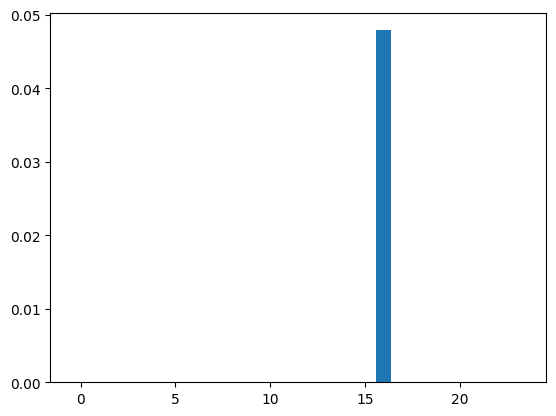

post-service-1-6dxwj


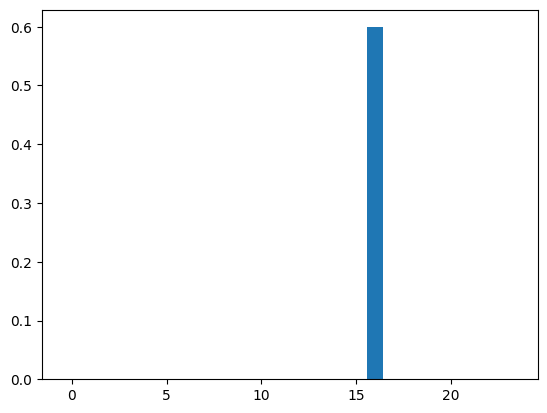

post-service-1-hh9cq


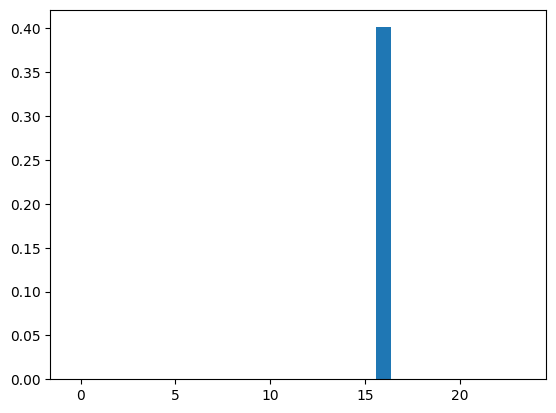

post-service-1-lxtpz


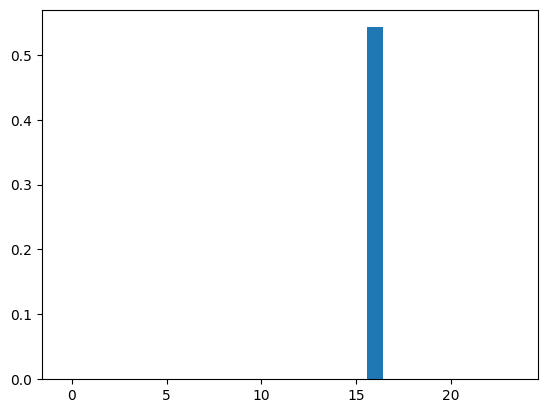

user-service-1-nmflq


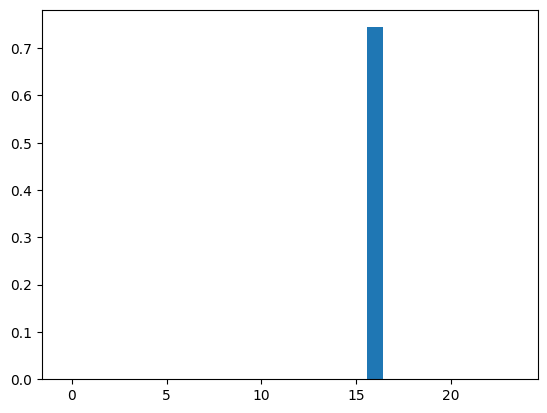

In [144]:
print("Cpu pod usage by hour")
for pod in metrics:
    print(pod["name"])
    cpus = []
    for i in range(24):
        cpus.append([])

    for point in pod["cpuUsage"]:
        cpus[int(point["hour"])].append(point["usage"])

    x=range(24)
    y=[]
    for i in range(24):
        if(len(cpus[i]) == 0):
            y.append(0)
        else:
            y.append(sum(cpus[i]) / len(cpus[i]))

    plt.bar(x,y)
    plt.show()



Cpu usage histogram
feed-service-1-6zz26


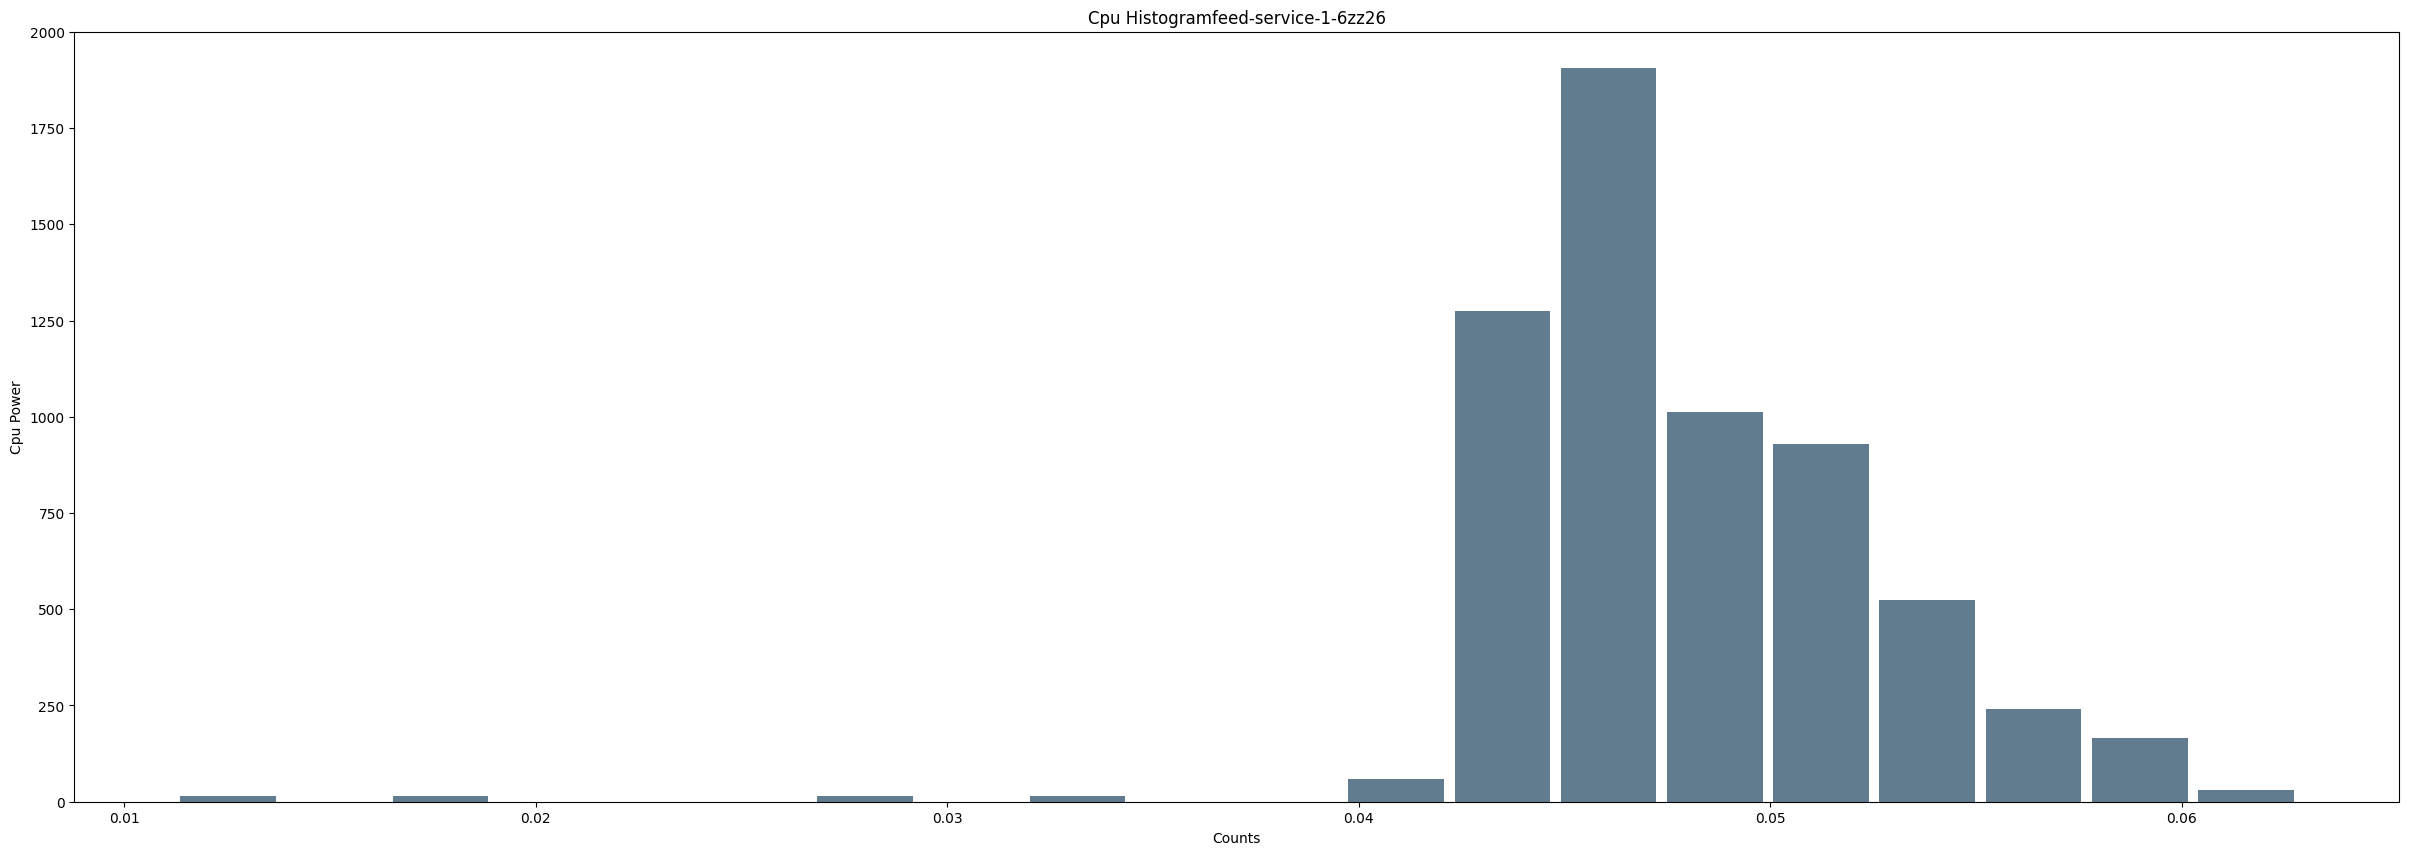

post-service-1-6dxwj


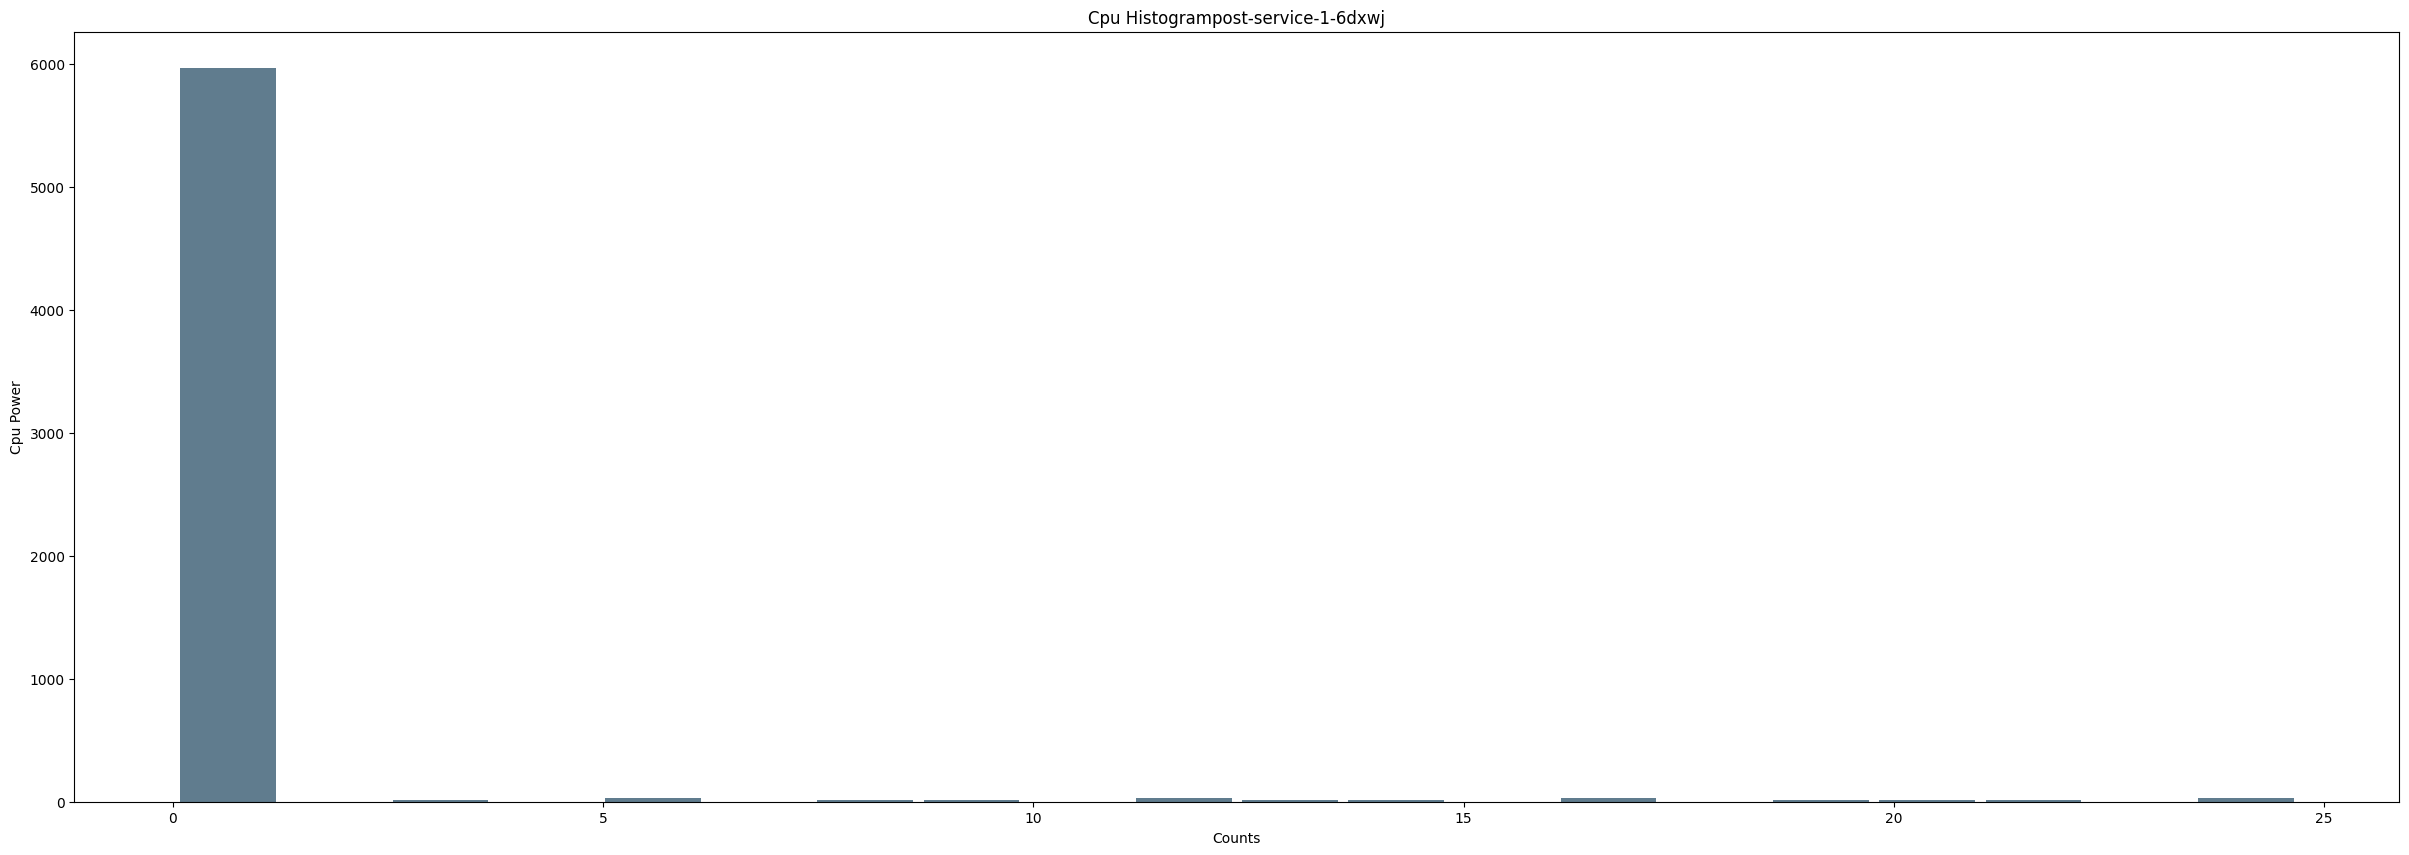

post-service-1-hh9cq


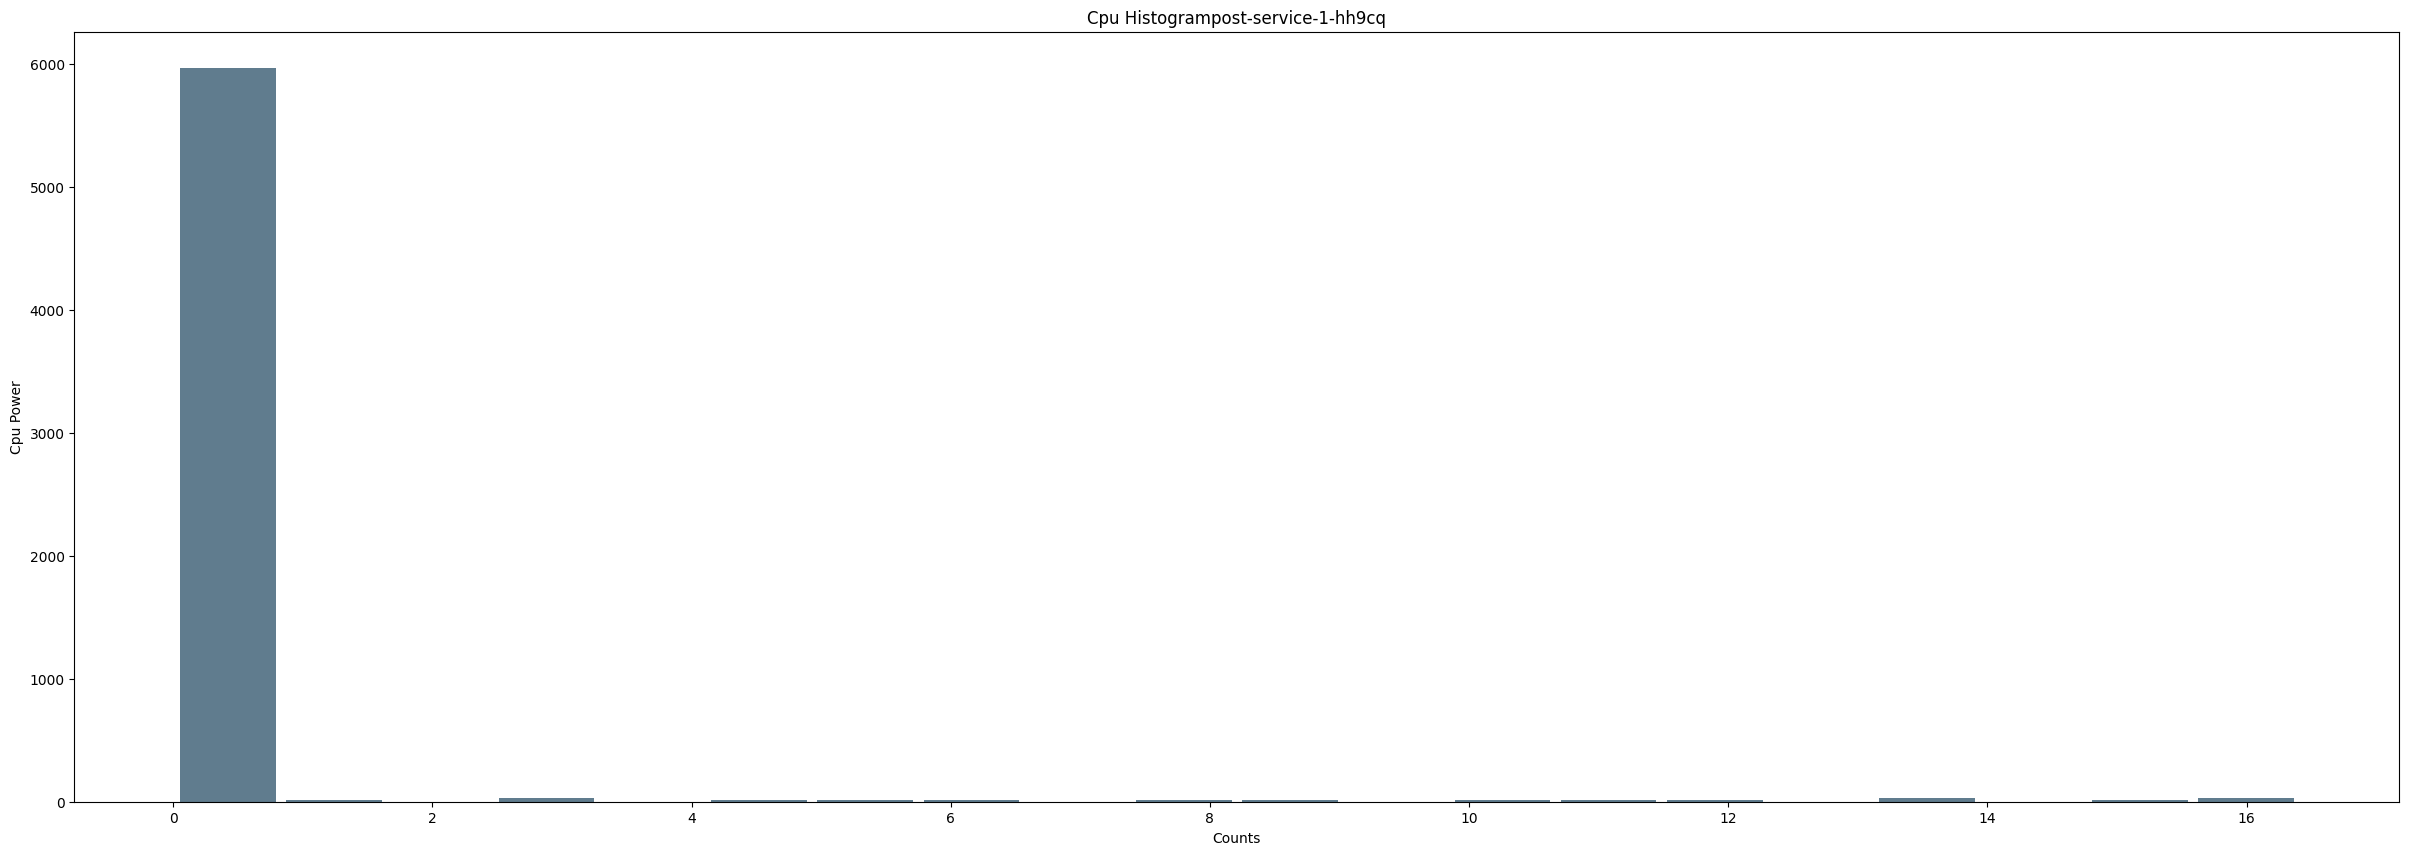

post-service-1-lxtpz


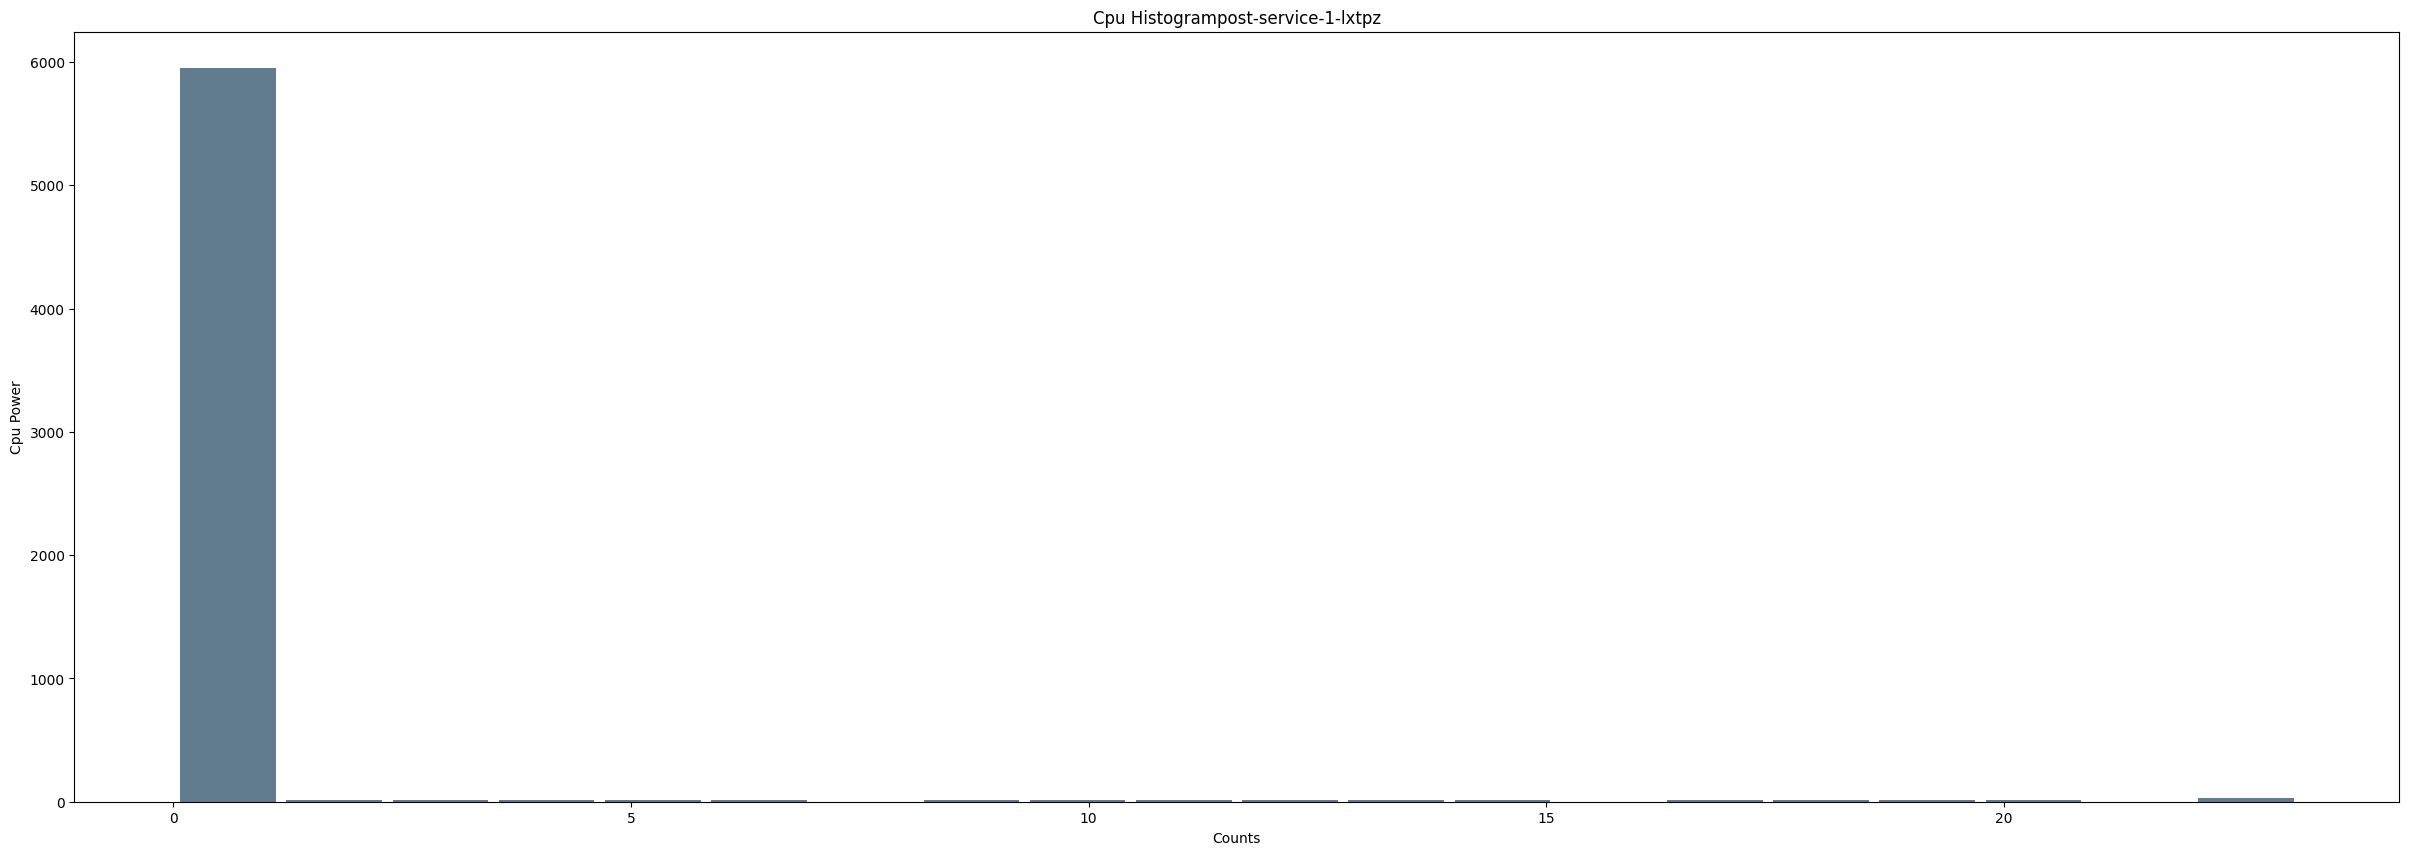

user-service-1-nmflq


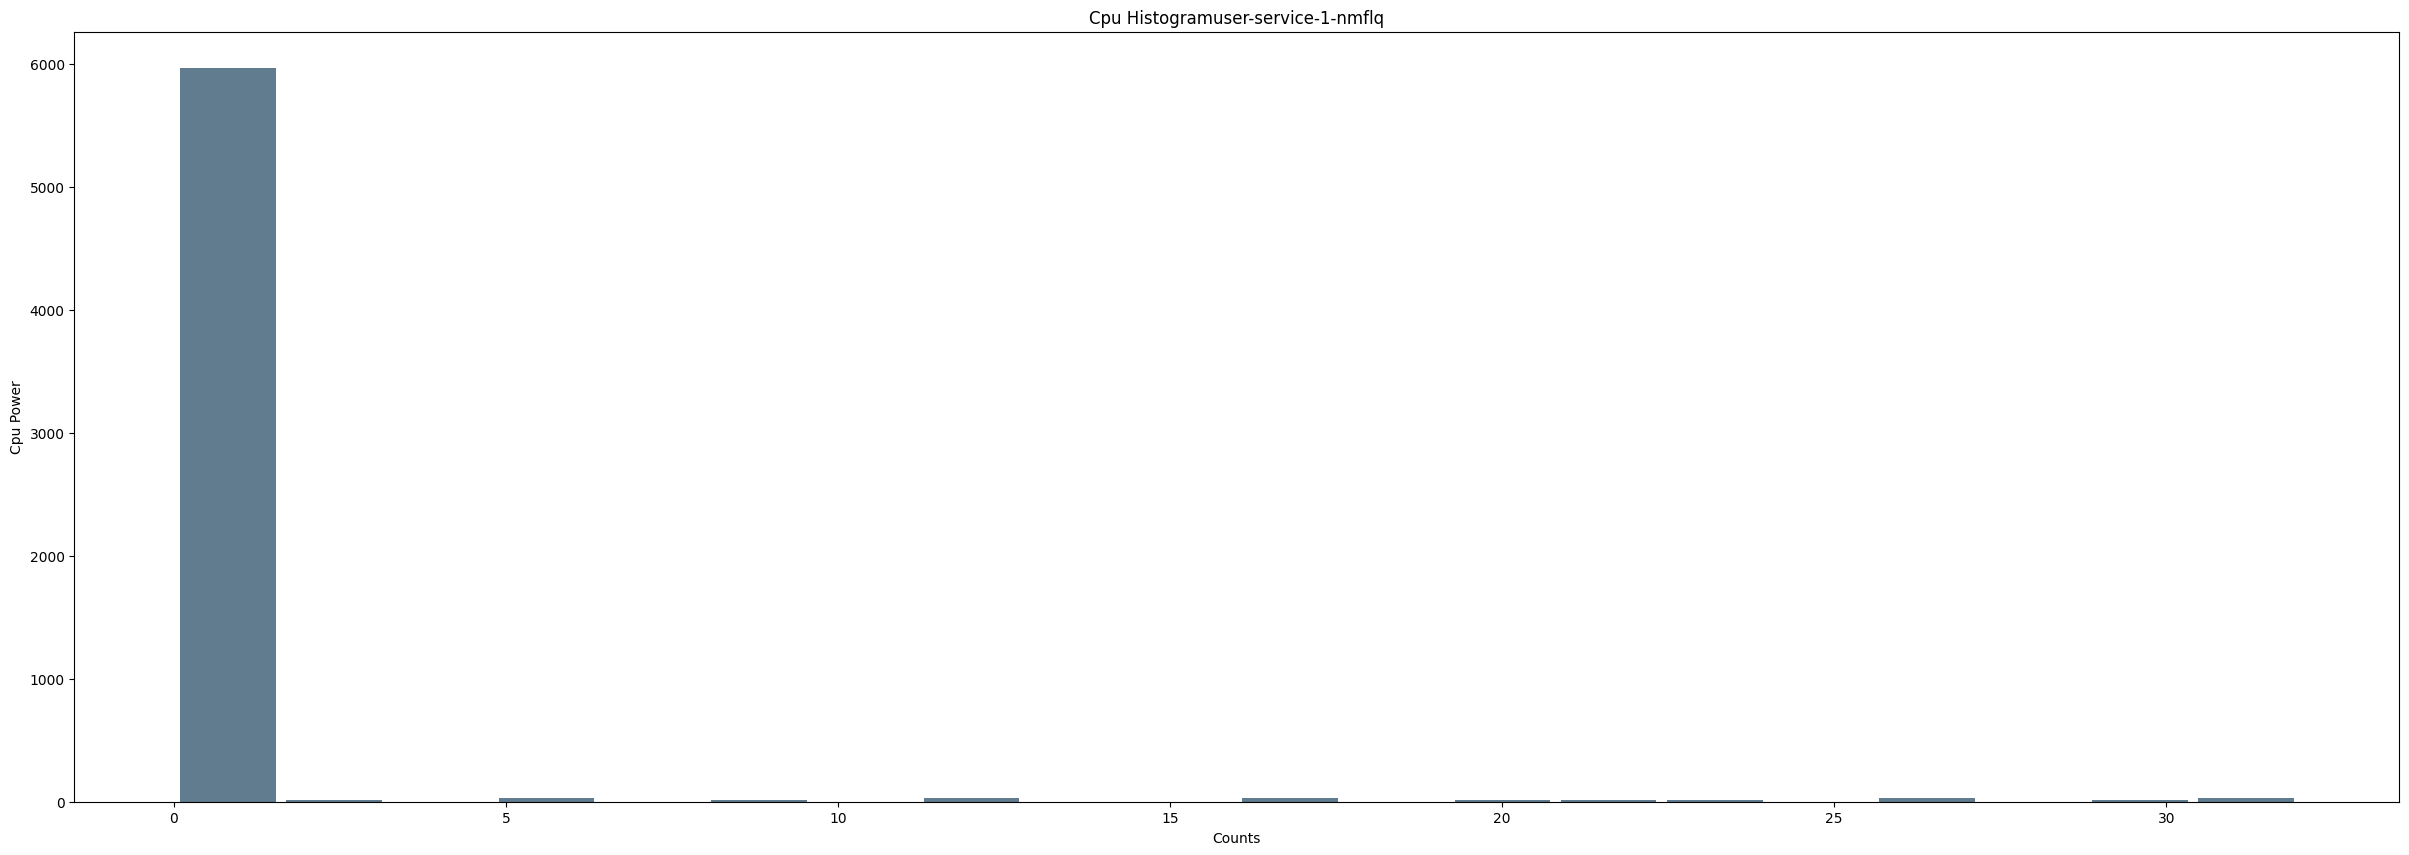

In [145]:
print("Cpu usage histogram")
for pod in metrics:
    print(pod["name"])
    cpus = []
    for point in pod["cpuUsage"]:
        cpus.append(point["usage"])
    # Generate data on commute times.
    commutes = pd.Series(cpus)
    commutes.plot.hist(grid=False, bins=20, rwidth=0.9,
                       color='#607c8e', figsize=(30, 10))
    plt.title('Cpu Histogram' + pod["name"])
    plt.xlabel('Counts')
    plt.ylabel('Cpu Power')
    plt.show()


feed-service-1-6zz26
Deviation: 0.004861970861971804
Mean: 0.04787978118749403


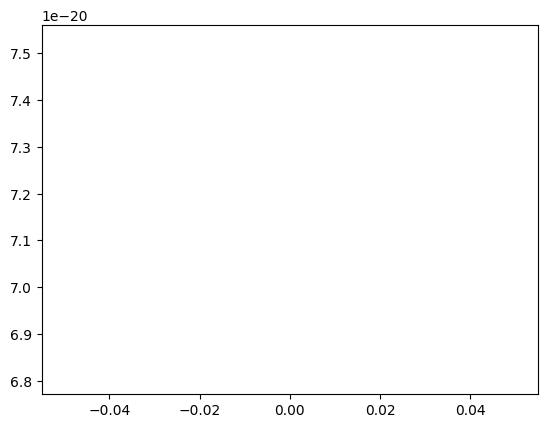

post-service-1-6dxwj
Deviation: 3.004767837858559
Mean: 0.5990747917096999


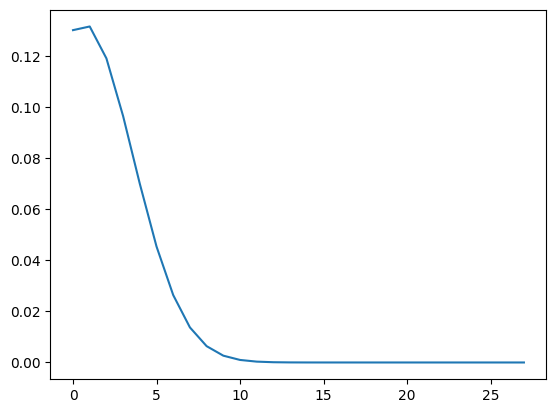

post-service-1-hh9cq
Deviation: 2.0043234739514584
Mean: 0.4012986147757605


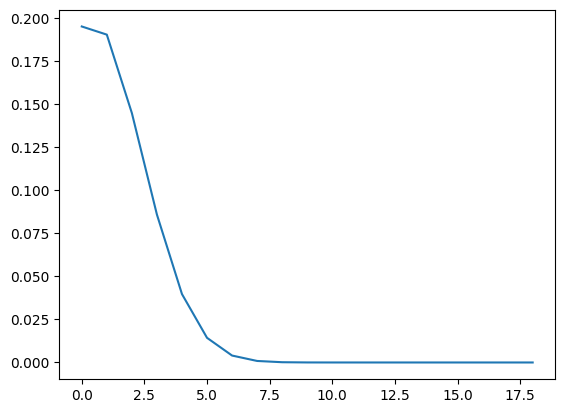

post-service-1-lxtpz
Deviation: 2.7957848062717012
Mean: 0.5424033104002723


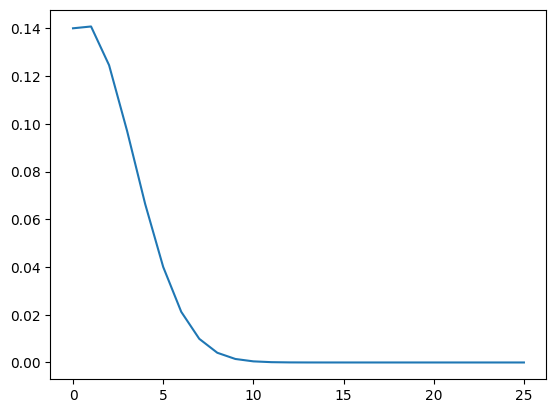

user-service-1-nmflq
Deviation: 3.9498858897365428
Mean: 0.7441052436615853


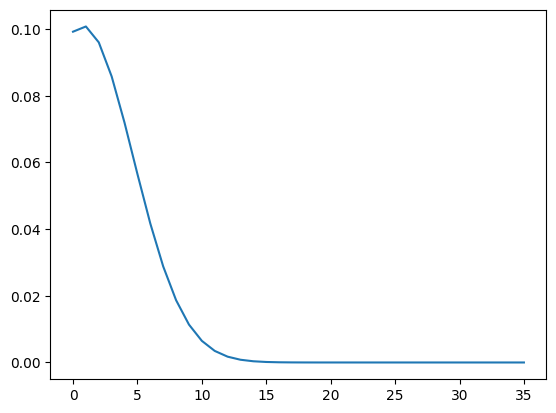

In [146]:

for pod in metrics:
    print(pod["name"])
    cpus = []
    for point in pod["cpuUsage"]:
        cpus.append(point["usage"])
        
    avg = sum(cpus)/len(cpus)
    maxcpu = max(cpus)
    
    print("Deviation: " + str(statistics.stdev(cpus)))
    print("Mean: " + str(avg))
    
    x_axis = np.arange(0, maxcpu*1.1, 1)
    plt.plot(x_axis, norm.pdf(x_axis, avg, statistics.stdev(cpus)))
    plt.show()

In [147]:
print("Calculate cpu ever propabolity")
for pod in metrics:
    print("==========================")
    print(pod["name"])
    print(pod["deploy"])
    cpus = []
    for point in pod["cpuUsage"]:
        cpus.append(point["usage"])
        
    prob = 0
    cpu = 0
    while prob < 0.8:
        cpu += 20 
        prob = norm(avg, statistics.stdev(cpus)).cdf(cpu)
    print("cpu:" + str(cpu))
    print("prop:" + str(prob))
    cpu_recomendation = cpu
    print("cpu:" + str(cpu*100/80))
    print("prop:" + str(prob))

Calculate cpu ever propabolity
feed-service-1-6zz26
feed-service
cpu:20
prop:1.0
cpu:25.0
prop:1.0
post-service-1-6dxwj
post-service
cpu:20
prop:0.9999999999264952
cpu:25.0
prop:0.9999999999264952
post-service-1-hh9cq
post-service
cpu:20
prop:1.0
cpu:25.0
prop:1.0
post-service-1-lxtpz
post-service
cpu:20
prop:0.9999999999971604
cpu:25.0
prop:0.9999999999971604
user-service-1-nmflq
user-service
cpu:20
prop:0.9999994560979808
cpu:25.0
prop:0.9999994560979808


In [152]:

print("Deploy calculations")
deployMetric = {}
    
for pod in metrics:
    print(pod["deploy"])
    if pod["deploy"] in deployMetric:
        for point in pod["cpuUsage"]:
            deployMetric[pod["deploy"]]["cpuUsage"].append(point)
        for point in pod["memoryUsage"]:
            deployMetric[pod["deploy"]]["memoryUsage"].append(point)
    else:
        deployMetric[pod["deploy"]] = {
            "name": pod["deploy"],
            "cpuUsage" : [],
            "memoryUsage" : []
        }
        for point in pod["cpuUsage"]:
            deployMetric[pod["deploy"]]["cpuUsage"].append(point)
        for point in pod["memoryUsage"]:
            deployMetric[pod["deploy"]]["memoryUsage"].append(point)

Deploy calculations
feed-service
post-service
post-service
post-service
user-service


Mean deploy Cpu usage by hour
feed-service


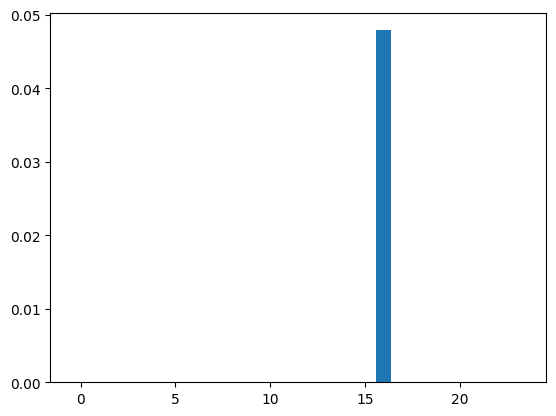

post-service


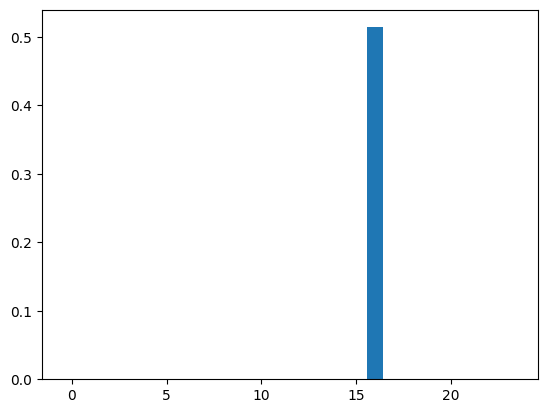

user-service


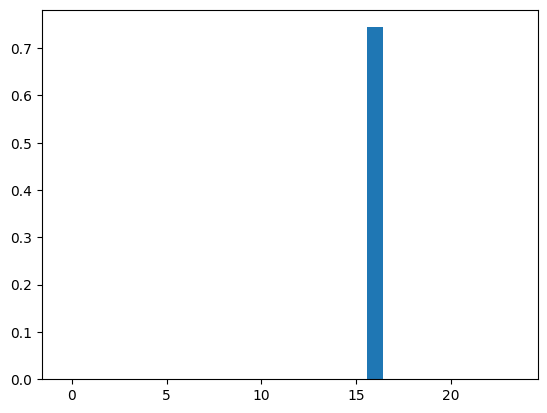

In [153]:
print("Mean deploy Cpu usage by hour")

for key in deployMetric:
    deploy = deployMetric[key]
    print(deploy["name"])
    cpus = []
    for i in range(24):
        cpus.append([])

    for point in deploy["cpuUsage"]:
        cpus[int(point["hour"])].append(point["usage"])

    x=range(24)
    y=[]
    for i in range(24):
        if(len(cpus[i]) == 0):
            y.append(0)
        else:
            y.append(sum(cpus[i]) / len(cpus[i]))

    plt.bar(x,y)
    plt.show()

Cpu usage histogram


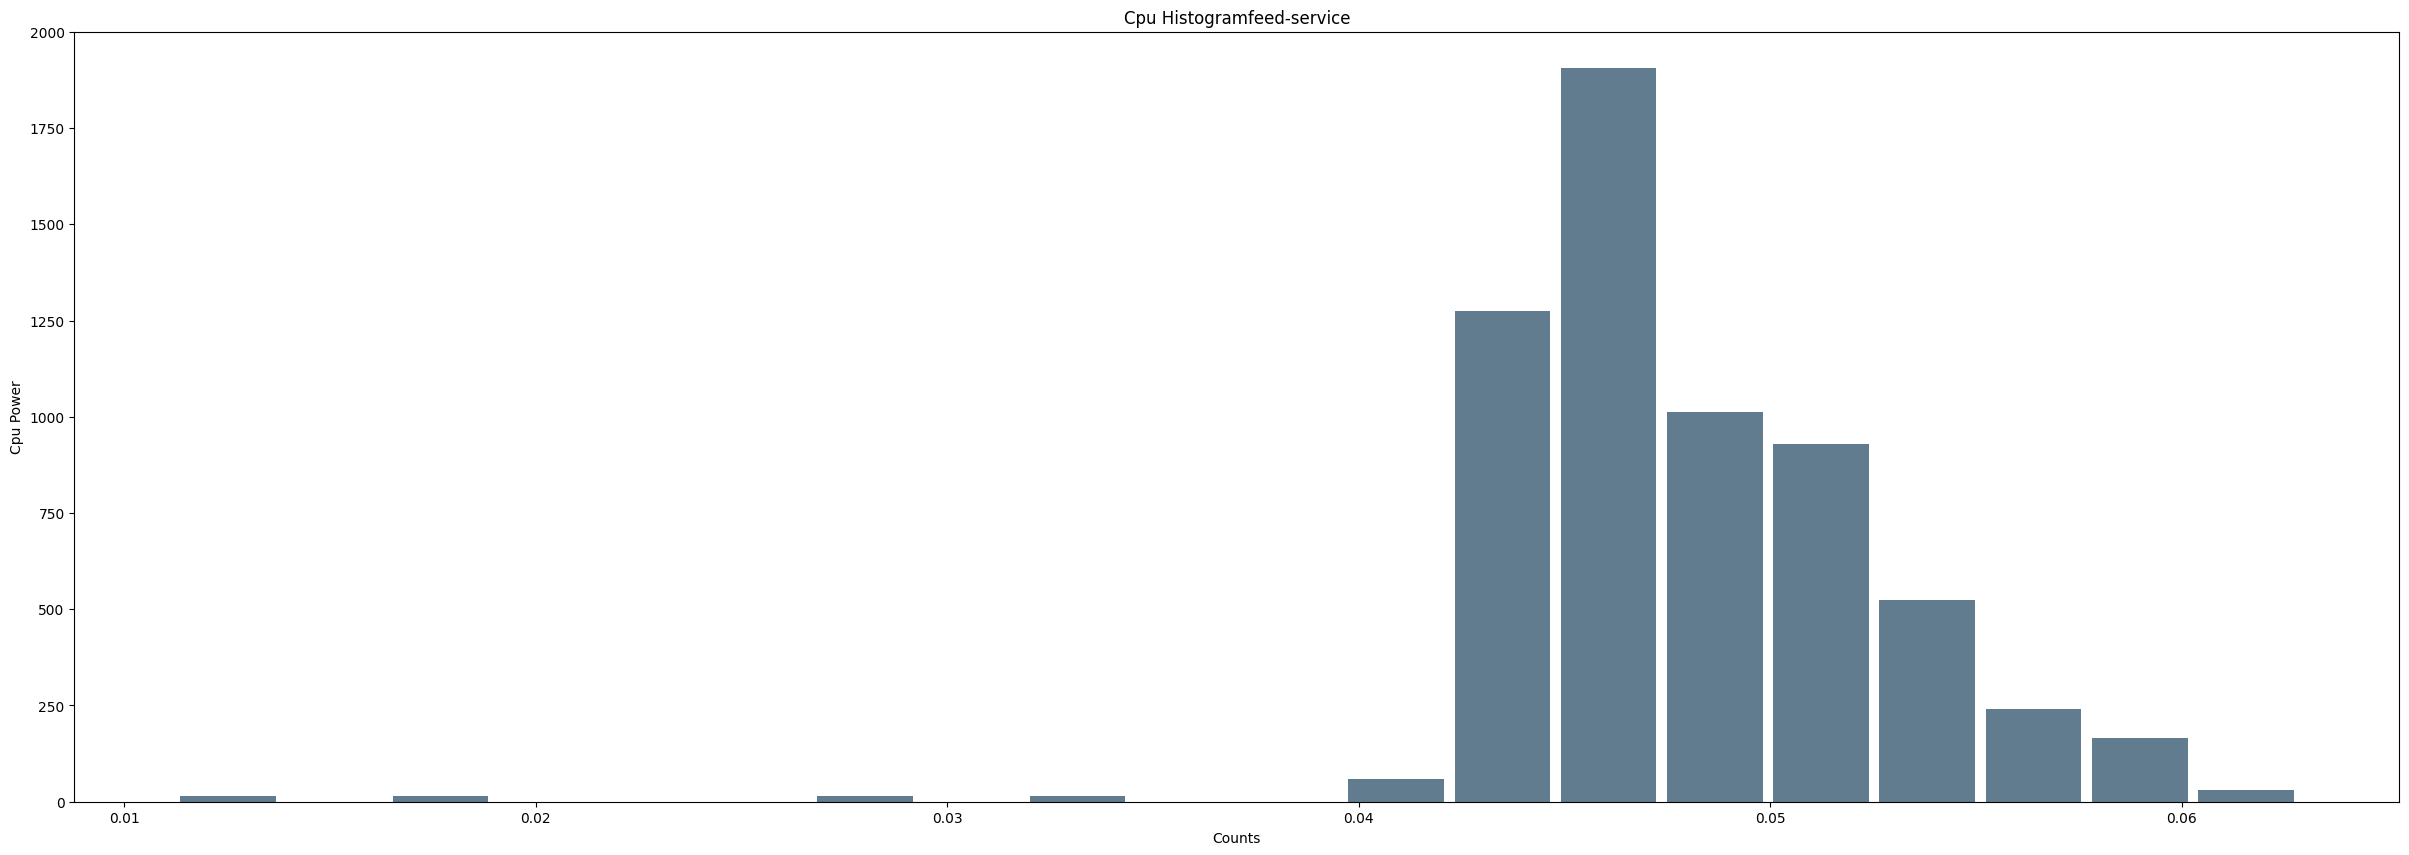

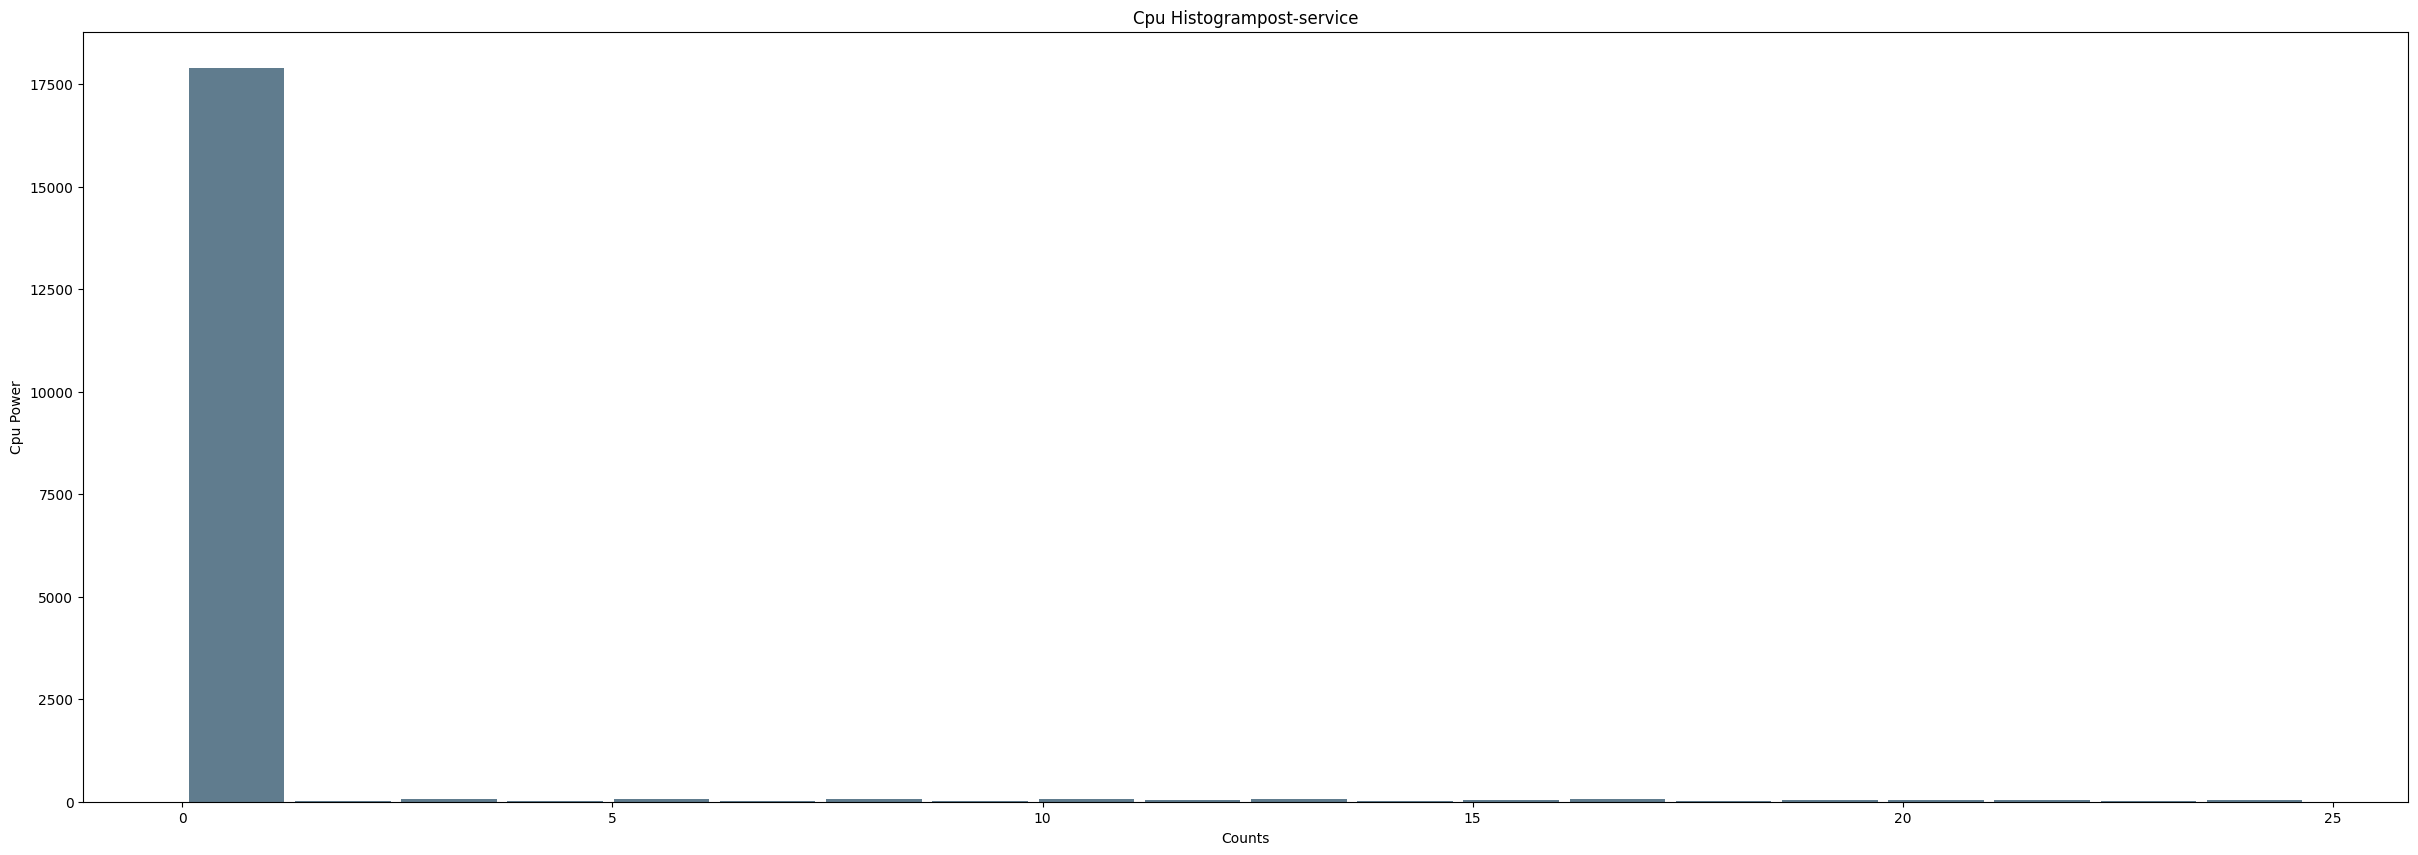

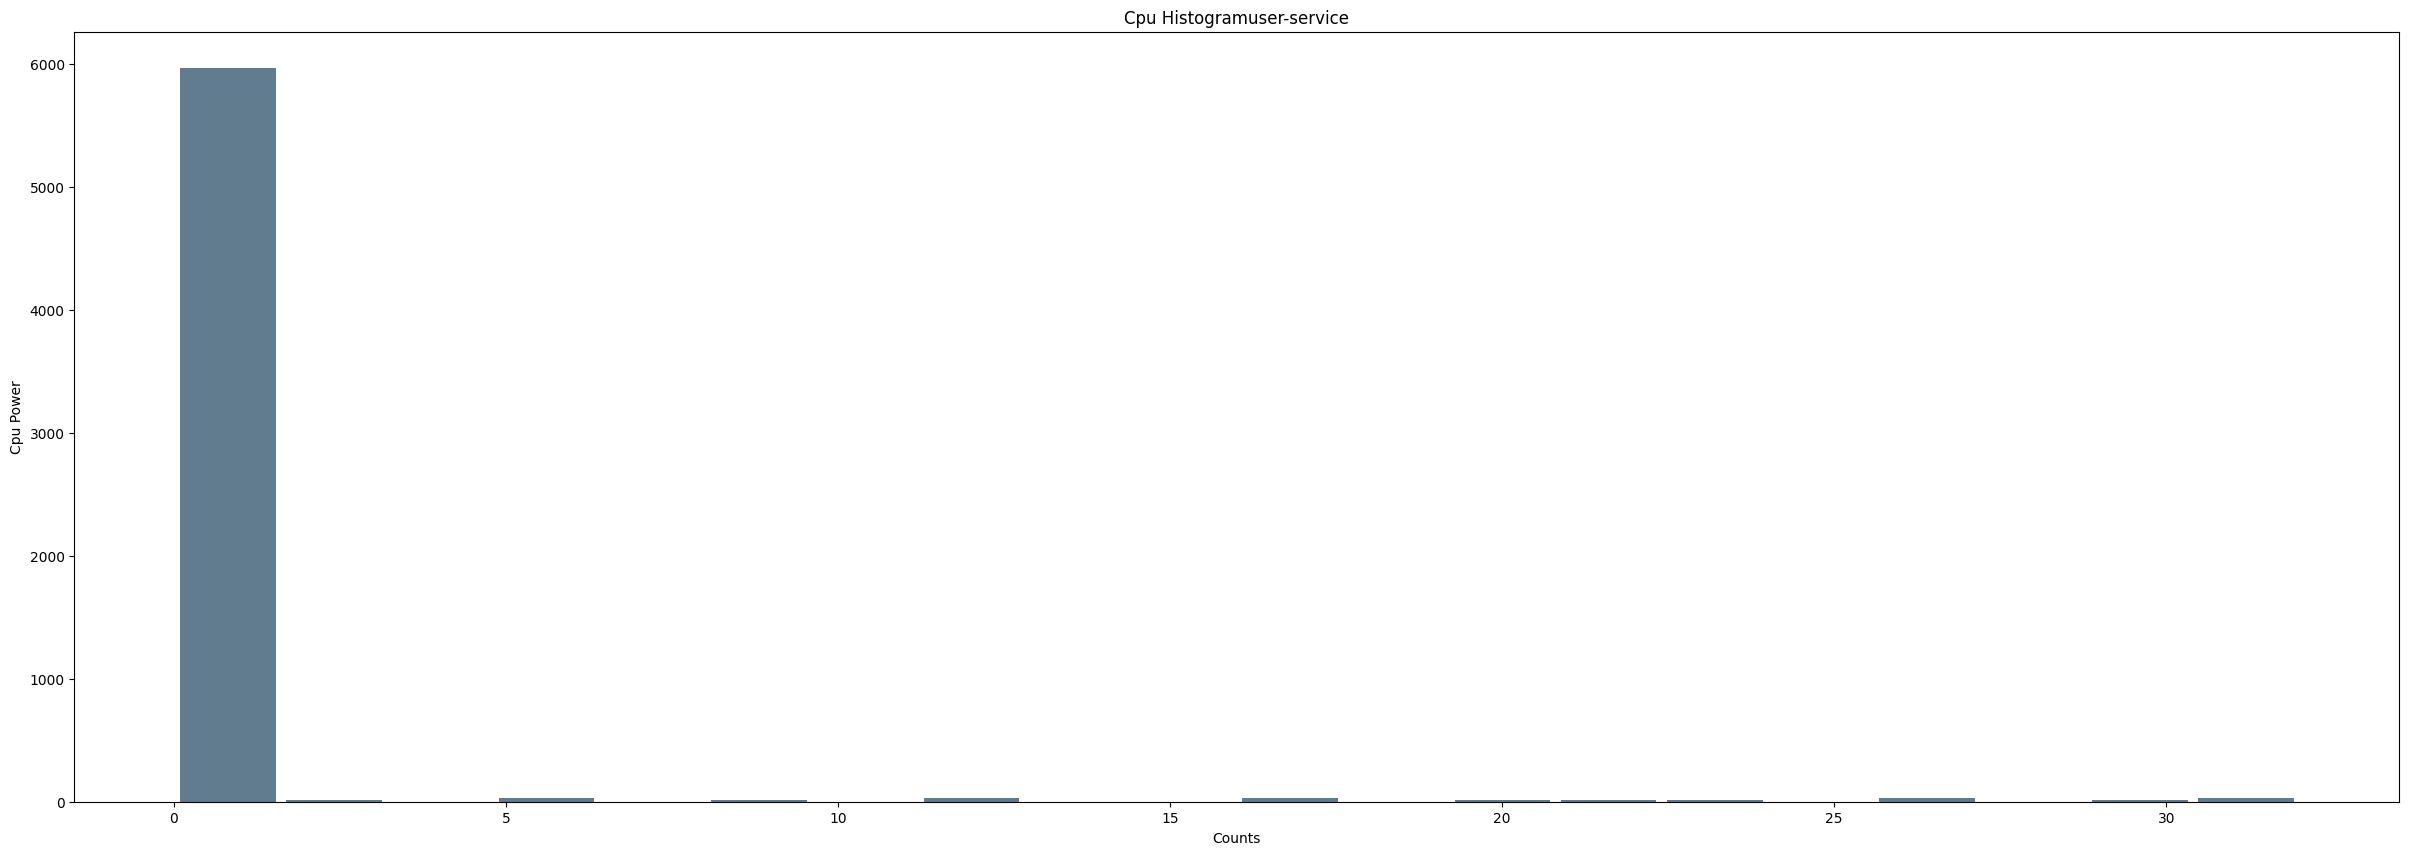

In [155]:
print("Cpu usage histogram")
for key in deployMetric:
    deploy = deployMetric[key]
    cpus = []
    for point in deploy["cpuUsage"]:
        cpus.append(point["usage"])
    # Generate data on commute times.
    commutes = pd.Series(cpus)
    commutes.plot.hist(grid=False, bins=20, rwidth=0.9,
                       color='#607c8e', figsize=(30, 10))
    plt.title('Cpu Histogram' + deploy["name"])
    plt.xlabel('Counts')
    plt.ylabel('Cpu Power')
    plt.show()

Cpu model
Deviation: 0.004861970861971804
Mean: 0.04787978118749403


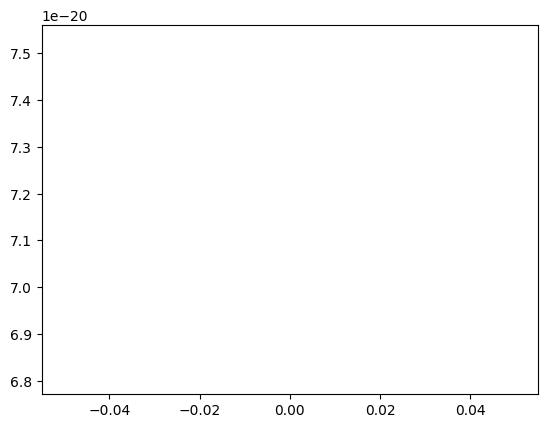

Deviation: 2.6382355034720266
Mean: 0.5142589056285759


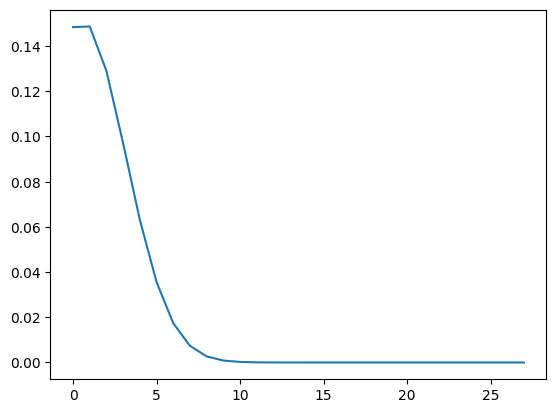

Deviation: 3.9498858897365428
Mean: 0.7441052436615853


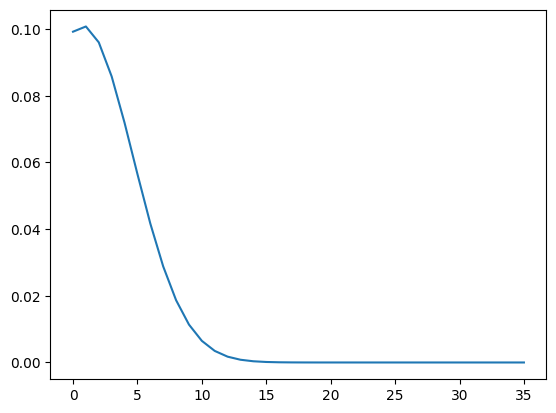

In [156]:
print("Cpu model")
for key in deployMetric:
    deploy = deployMetric[key]
    cpus = []
    for point in deploy["cpuUsage"]:
        cpus.append(point["usage"])
        
    avg = sum(cpus)/len(cpus)
    maxcpu = max(cpus)
    
    print("Deviation: " + str(statistics.stdev(cpus)))
    print("Mean: " + str(avg))
    
    x_axis = np.arange(0, maxcpu*1.1, 1)
    plt.plot(x_axis, norm.pdf(x_axis, avg, statistics.stdev(cpus)))
    plt.show()

In [157]:
print("Calculate cpu ever propabolity")
for key in deployMetric:
    deploy = deployMetric[key]
    print("==========================")
    print(deploy["name"])
    cpus = []
    for point in deploy["cpuUsage"]:
        cpus.append(point["usage"])
        
    prob = 0
    cpu = 0
    while prob < 0.8:
        cpu += 20 
        prob = norm(avg, statistics.stdev(cpus)).cdf(cpu)
    print("cpu:" + str(cpu))
    print("prop:" + str(prob))
    cpu_recomendation = cpu
    print("cpu:" + str(cpu*100/80))
    print("prop:" + str(prob))

Calculate cpu ever propabolity
feed-service
cpu:20
prop:1.0
cpu:25.0
prop:1.0
post-service
cpu:20
prop:0.9999999999998548
cpu:25.0
prop:0.9999999999998548
user-service
cpu:20
prop:0.9999994560979808
cpu:25.0
prop:0.9999994560979808


In [ ]:
from scipy.interpolate import lagrange
x_old = []
y = []

jump = 10
divid = 0
multiplier = 1

initpoint = cpu_recomendation
grow = 1
mainpoint = initpoint*grow

bigjump = 1

def f(x):
    y = []
    for i in x:
        point = (jump + i*grow)/(jump+mainpoint)*10
        try:
            value = (math.log(point*bigjump, 10) - divid)*multiplier
        except:
            print(i)
            print(point)
            print(bigjump)
            print(jump)
            print(mainpoint)
            raise "Ruim"
        y.append(value)
    return y


interk = 0
finded = False
maxp = 1000
while(interk< maxp and not finded):
    #reset loop
    interj = 0
    
    grow = 1
    mainpoint = initpoint*grow
   
    interk +=1
    print(interk)
    bigjump += 100


    while(interj < maxp and not finded):
        #inter
        interj +=1
        grow += 10
        mainpoint = initpoint*grow
        
        #reset loop
        interi = 0        
        jump = 10
        while(interi < maxp and not finded):
            #inter
            interi += 1
            jump += 50
            
            #reset
            divid = 0
            multiplier = 1
            
            #define param
            divid = f([0])[0]
            if(f([initpoint])[0] ==0):
                continue
            multiplier = 1/f([initpoint])[0]
            
            #test
            if(f([initpoint*2])[0] > 1.8 and f([initpoint*2])[0] < 1.85 and f([initpoint*10])[0] > 5.5 and f([initpoint*10])[0] < 5.6):
                finded = True
print("final")
print([0, initpoint, 2000, 10000])
print(f([0, initpoint, 2000, 10000]))

fig = plt.figure(figsize = (10,8))
x_new = []
for i in range(1000):
    x_new.append(i*50)  
plt.plot(x_new, f(x_new), 'b' )
plt.title('Log speedup')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()